https://www.kaggle.com/PromptCloudHQ/imdb-data/data / 
https://www.kaggle.com/tmdb/tmdb-movie-metadata/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
% matplotlib inline
import seaborn as sns
import scipy.stats as stats
import json
import re

In [2]:
from sklearn.preprocessing import normalize

# Narrative Analytics and Experimentation: The Movie Edition
***
***

### The film industry is one of many that has been adversely affected by the widespread usage of the internet.  
#### - Online streaming platforms (i.e., Netflix, Hulu, Amazon Prime) are a popular medium of movie/tv consumption as it enables consumers/viewers to be able to watch movies from the comforts of their own home. <br> <br> - Making matters worse is the rise in popularity in premium television content which require consumers to subscribe to some platform in order to watch these "premium" content (think *Mad Men*, *Game of Thrones*, *Stranger Things* ). <br> <br> - As popular as these shows are, these online platforms offer other content as well - movies and television content from other production studios - that further entice consumers to forego going to the theater in favor of watching (or doing) something else at home.  

In [3]:
# call df of boxoffice ; from the-numbers.com
bo = pd.read_csv('boxoffice.csv')

# column names cut off, renaming
bo.rename(columns={'Total Inflation':'infltn_adj', 'Average': 'ticket_price', 
                   'Tickets Sold':'tickets', 'Total Box Office':'box_office'}, inplace=True)

# drop first row that is an extension of column names
bo.dropna(axis=0, how='any', inplace=True)

# drop row for 2018, as it is incomplete and annualized
bo = bo[bo['Year']!=2018.0].reset_index(drop=True)

# reset another time to get number mapping to 'Year'
bo = bo.reset_index()
bo.rename(columns={'index':'year'}, inplace=True)

# change year from float to int
bo.Year = bo.Year.apply(lambda x: int(x))

# change type of ticket price, str to float
cols = ['box_office', 'infltn_adj']
for c in cols:
    # .replace takes out commas, [1:] takes out dollar symbol
    bo[c] = bo[c].apply(lambda x: int(x.replace(',', '')[1:]))
bo['tickets'] = bo['tickets'].apply(lambda x: int(x.replace(',', '')))
bo['ticket_price'] = bo['ticket_price'].apply(lambda x: float(x[1:]))

# flip 'year' column
bo['year'] = bo.year.sort_values(ascending=False).values
bo = bo.reindex(bo['year'])

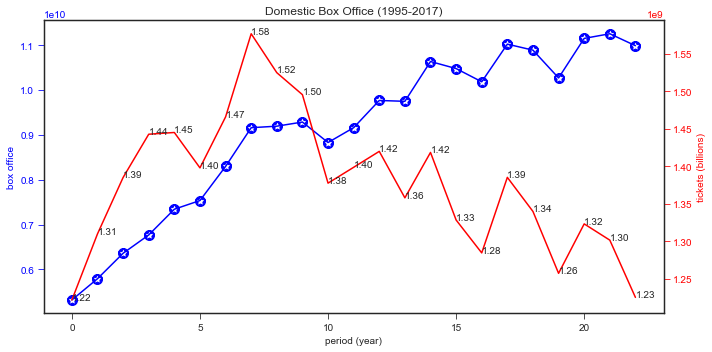

In [4]:
sns.set_style('ticks')

# copied, pasted from plt docs for study


# ('5' is number of vertices for star)
star = mpath.Path.unit_regular_star(5)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
# i think 2 separate things are being concatenated: vertices and codes... what are they?
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)



fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(bo['year'], bo['box_office'], 'b-', marker=cut_star, markersize=10)
ax1.set_title('Domestic Box Office (1995-2017)')
ax1.set_xlabel('period (year)')
ax1.set_ylabel('box office', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(bo.year, bo.tickets, 'r-')
for a,b in zip(bo['year'], bo['tickets']):
    plt.text(a, b, str("%.2f" % round((b/1000000000),2)))
    # rounding is complicated apparently; "%.2f" % round(a, 2) works in print and str(), etc
ax2.set_ylabel('tickets (billions)', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

##### There is a clear sign of decreasing ticket sales.  
#### Despite this, the box office has been still increasing, albeit at a visibly reduced rate, implying that there is another variable that is not only offsetting the decrease in ticket sales, but also causing an overall increase that we see for the box office.
-plug [rounding floats](https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points)-

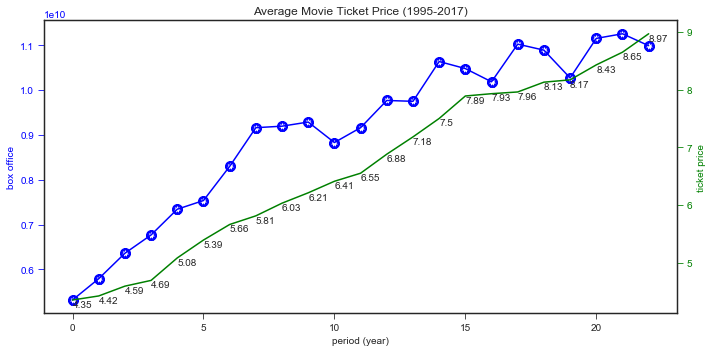

In [5]:
fig, ax1 = plt.subplots(figsize=(10,5))


# ('7' is number of vertices for star)
star = mpath.Path.unit_regular_star(7)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
# i think 2 separate things are being concatenated: vertices and codes... what are they?
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

ax1.plot(bo['year'], bo['box_office'], 'b-', marker=cut_star, markersize=10)
ax1.set(title='Average Movie Ticket Price (1995-2017)', xlabel='period (year)')
ax1.set_ylabel('box office', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(bo.year, bo.ticket_price, 'g-')
for a, b in zip(bo.year, bo.ticket_price):
    plt.text(a, b, str(b), verticalalignment='top')
ax2.set_ylabel('ticket price', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()

##### Increasing ticket prices have kept the box office steadily increasing
- *particularly in recent years* where the growth in ticket price outpaces the growth in box office.

Since the box office is essentially just the *"ticket price" times "ticket sales"*, we cannot make any assumptions with just these variables, as the **box office** is synonymous with "revenue", and **revenue is a dependent variable.**
>There are also undoubtedly external factors influencing the box office as well; the research will exclude such variables, such as:<br>
- economic factors, one-off events (natural disasters), competition across industries
- also take into account actual supply-demand relationship of this product
    - product could be inelastic

In [6]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [7]:
tmdb = load_tmdb_movies('tmdb_5000_movies.csv')

In [8]:
# just wow
def get_dv(keywords):
    '''retrieves dictionary values from list of dictionaries
    Parameters: keywords (list of dictionaries)
    '''
    return ','.join([x['name'] for x in keywords])

In [9]:
# overwriting columns with list of dictionaries as values
tmdb['production_companies'] = tmdb['production_companies'].apply(lambda x: get_dv(x))
tmdb['genres'] = tmdb['genres'].apply(lambda x: get_dv(x))
tmdb['keywords'] = tmdb['keywords'].apply(lambda x: get_dv(x))

In [10]:
# Cleaning data 

tmdb.rename(columns={'title': 'Title'}, inplace=True)

# excluding movies with 0 revenue, budget, runtime
# including only movies with english as original language (want Hollywood movies)
tmdb['studio_count'] = tmdb['production_companies'].str.len()
tmdb = tmdb[(tmdb['studio_count'] > 0) & (tmdb['revenue'] > 0) & (tmdb['budget'] > 0) & (tmdb['runtime'] > 0)
           & (tmdb['original_language'] == 'en')]


tmdb = tmdb.reset_index(drop=True)

#changing one value to include global box office
tmdb.loc[13, 'revenue'] = 260502115
tmdb.loc[283, 'revenue'] = 325338851

# adding year
tmdb['year'] = tmdb['release_date'].apply(lambda x: str(x)[:4])

# change revenue, budget, (adding column) profit to be in millions
tmdb['rev'] = tmdb.revenue.apply(lambda x: x/1000000)
tmdb['budg'] = tmdb.budget.apply(lambda x: x/1000000)
tmdb['prof'] = tmdb['rev'].subtract(tmdb['budg'])

In [11]:
# columns of interest
cols_tmdb = ['Title', 'year', 'rev', 'budg', 'prof', 'genres', 'production_companies', 'popularity', 'vote_average', 'vote_count', 'release_date']
tmdb1 = tmdb[cols_tmdb]

# Lose ~1000 rows when attempting to capture "recent" observations only
tmdb1 = tmdb1[tmdb1['year'] >= '1989']
tmdb1['year'] = tmdb1['year'].apply(lambda x: int(x))

### Determining the main drivers of the box office requires an understanding of the industry's supply-demand relationship.
Aside from the points mentioned earlier, there could be various idiosyncratic reasons as to why people are no longer going to the movies as often as in years past:
- Too many comic book movies
- Too many blockbusters
- Too many sequels
- Too much to choose from...

The last point may seem a bit ridiculous, except if you consider the [studies](https://www.nytimes.com/2010/02/27/your-money/27shortcuts.html) linking indecision with too many options. And there is clearly a theme of excess in the film industry.  

#### After the implementation of Disney's *Marvel Cinematic Universe* (MCU), every other major studio decided to try and emulate Disney's model of a "shared universe" of blockbusters
>"A shared universe or shared world is a set of creative works where more than one writer (or other artist) independently contributes a work that can stand alone but fits into the joint development of the storyline, characters, or world of the overall project. It is common in genres like science fiction." - via wikipedia 

#### There has also been a trend of either remaking, making sequels of, or just reusing old creative content.

<img src="studiofranch.jpg" alt="Drawing" style="width: 450px;"/>
- Most circles are franchises, only the circles with multiple entries are "shared universes"  <br>
***
***

###  With the repurcussions of the housing crash still sitting in everyone's mind - making it harder to justify the ever-increasing price of movie tickets and concession-stand items - consumers are becoming more selective and cost-conscious. 
#### They want more bang for their buck, and that almost always means blockbusters.


In [12]:
avg_budg = tmdb1.groupby('year')['budg'].mean()
avg_rev = tmdb1.groupby('year')['rev'].mean()

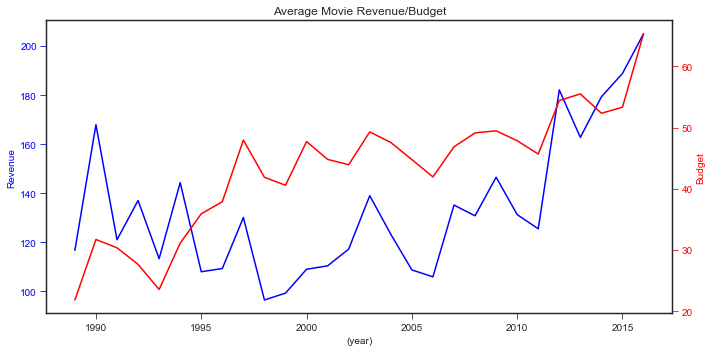

In [13]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(avg_rev.index, avg_rev, 'b-')
ax1.set(title='Average Movie Revenue/Budget', xlabel='(year)')
ax1.set_ylabel('Revenue', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(avg_rev.index, avg_budg, 'r-')
ax2.set_ylabel('Budget', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [14]:
one00 = tmdb1[tmdb1['budg'] > 100].groupby('year')['Title'].count()
one50 = tmdb1[tmdb1['budg'] > 150].groupby('year')['Title'].count()

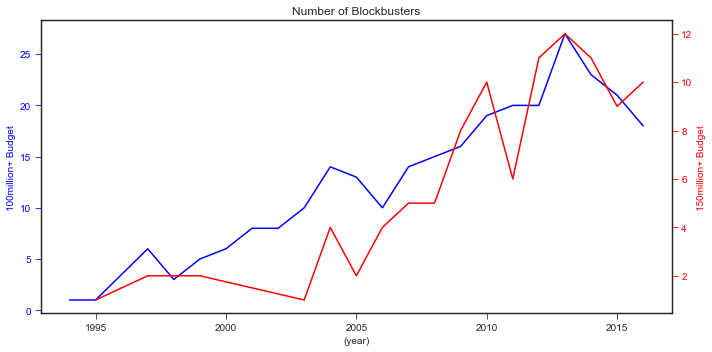

In [15]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(one00.index, one00, 'b-')
ax1.set(title='Number of Blockbusters', xlabel='(year)')
ax1.set_ylabel('100million+ Budget', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(one50.index, one50, 'r-')
ax2.set_ylabel('150million+ Budget', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


With studios producing more and more blockbusters, the benchmarks for box-office success having become blurred due to the outsized performance of Disney's Marvel films, and consumers having more options to choose from; the movie industry is in a **period of disruption and innovation** that could ultimately lead to a changing of the guard (already one of the *major 6 studios* are showing signs of an unrecoverable fall from grace, following the footsteps of MGM studios). 


### But if you were only to take a look at Disney, just producing box-office hit after hit after hit, it appears doubtful that there really is any sort of volatility or disruption in the industry.
***
***


So, what makes Disney so different?

Does Disney actually perform better than the other major studios? or is all the extra attention merely the product of Disney's brand?  
Asking these questions in a more industry-wide manner...

## What are the main factors driving the box-office success for movies? 
    
### Is it just Disney, who happened to uncover the formula to success?

#### The research will be focused around determining the variables that drive a movie's box-office performance.

***
***

### Data Exploration and Discovery 
*Start off by looking into dataset to look for potential variables with influence over box office*
- One of the more influential variables in this dataset is the **production studio(s)** of the movie, and that could very well be the answer to this research: **certain film studios simply make better movies.**

In [16]:
# seperating non-Disney Marvel movies, which have no direct relationship with Disney
f_not_dis = tmdb1[tmdb1.production_companies.str.contains('Marvel') & tmdb1.production_companies.str.contains('Fox')]
s_not_dis = tmdb1[tmdb1.production_companies.str.contains('Marvel') & tmdb1.production_companies.str.contains('Columbia')]
u_not_dis = tmdb1[tmdb1.production_companies.str.contains('Marvel') & tmdb1.production_companies.str.contains('Universal')]
pac_rim = tmdb1[tmdb1.production_companies.str.contains('Disney Double Dare')]

p_r = tmdb1.loc[pac_rim.index, 'production_companies'].str.replace('Disney Double Dare You','')
f_marv = tmdb1.loc[f_not_dis.index, 'production_companies'].str.replace('Marvel', 'marvel')
s_marv = tmdb1.loc[s_not_dis.index, 'production_companies'].str.replace('Marvel', 'marvel')
u_marv = tmdb1.loc[u_not_dis.index, 'production_companies'].str.replace('Marvel', 'marvel')

In [17]:
# contd.
tmdb1.loc[pac_rim.index, 'production_companies'] = p_r
tmdb1.loc[f_not_dis.index, 'production_companies'] = f_marv
tmdb1.loc[s_not_dis.index, 'production_companies'] = s_marv
tmdb1.loc[u_not_dis.index, 'production_companies'] = u_marv

In [18]:
fox_1 = ['Fox']
lgf_1 = ['Lions', 'Summit']
sony_1 = ['Sony', 'Columbia']
univ_1 = ['Universal', 'DreamWorks']
dis_1 = ['Disney', 'Pixar', 'Marvel']
wb_1 = ['Warner', 'New Line Cinema']
para_1 = ['Paramount']

dict_studios = {'dis':dis_1, 'univ':univ_1, 'wb':wb_1, 'fox':fox_1, 'sony':sony_1, 'para':para_1, 'lgf':lgf_1 }
list_studios = list(dict_studios.keys())

In [19]:
def studio_reg(studio):
    # okay for now, but set boundaries on regex
    temp = re.compile('|'.join(studio))
    return temp

In [20]:
# separate dataframes for each major studio (plus Lionsgate which is not a major studio but closest to it)

dis = tmdb1[tmdb1.production_companies.str.contains(studio_reg(dis_1))].reset_index()
fox = tmdb1[tmdb1.production_companies.str.contains(studio_reg(fox_1))].reset_index()
wb = tmdb1[tmdb1.production_companies.str.contains(studio_reg(wb_1))].reset_index()
univ = tmdb1[tmdb1.production_companies.str.contains(studio_reg(univ_1))].reset_index()
sony = tmdb1[tmdb1.production_companies.str.contains(studio_reg(sony_1))].reset_index()
para = tmdb1[tmdb1.production_companies.str.contains(studio_reg(para_1))].reset_index()
lgf = tmdb1[tmdb1.production_companies.str.contains(studio_reg(lgf_1))].reset_index()


In [21]:
for studio, subsids in dict_studios.items():
    tmdb1[studio] = tmdb1['production_companies'].str.contains(studio_reg(subsids)).apply(lambda x:1 if x else 0)

In [22]:
def ftr_groupby(list_feature, cols, df1=tmdb1):
    '''group by features, return sns compatible df'''
    df = pd.DataFrame()
    for studio in list_feature:
        temp = df1.groupby(studio)[cols].get_group(1)
        temp['studio'] = studio
        temp['metric'] = cols[1]
        temp.rename(columns={cols[1]:'kpi'}, inplace=True)
        df = pd.concat([df, temp])
        
    return df
# the function groups by feature and returns sns-compatible df (only one feature)
# another function when groupby multiple features? or one function do both

In [23]:
studios_rev = ftr_groupby(list_studios, ('Title', 'rev'))
studios_budg = ftr_groupby(list_studios, ('Title', 'budg'))
studios_concan = pd.concat([studios_rev, studios_budg], axis=0)

From the boxplots below, *Disney* appears to have a better track record than ***most*** of the other studios, but there are a few points worth mentioning. 
- From an **eye test**, Disney is a noticeably better studio;
- Disney's boxplots (mainly focusing on revenue) are right-skewed (mean>median); 
- some of the **other studios have many outliers** past the *right* whisker - which may eventually result in a boxplot distribution, or shape, similar to Disney's (specifically Warner Bros.).

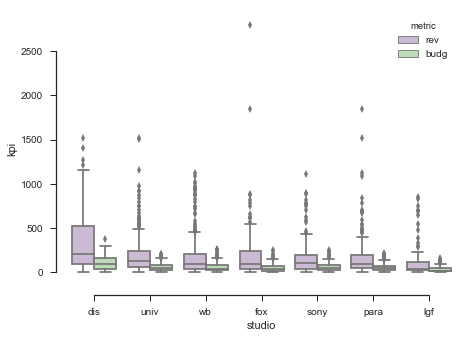

In [24]:
sns.set(style="ticks", )
ax, fig = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="studio", y='kpi', hue='metric', data=studios_concan, palette="PRGn")
sns.despine(offset=10, trim=True)


***
*Before* analyzing the studios relative to each other, validating a studio's performance will be done first in order to account for all variables and features that drive the KPIs.

By doing this, we hope to determine if there exists any "outliers" in a studio's performance and the variables/features that caused the outlier.
<br>Thereafter, we would group the studios' movies by these variables/features, which may provide more insights and accurate test results. 

As major studios usually own a few other studios that function as subsidiaries, **grouping into individual "sub-studios"** provides a simple and insightful option for our base analysis.
- This is especially true for Disney, as Disney's subsidiary studios are relatively huge as far as subsidiary studios go
- examples of A/A testing would include:
    - disney movies against pixar movies
    - non-animated movies against animated movies

In [25]:
# Disney's portfolio includes two big brands, Marvel and Pixar
# separate each studio

dis_pix = 'Pixar Animation Studios'
dis_marv = 'Marvel Studios'

dis_only = dis[dis.production_companies.apply(lambda x: dis_pix not in x and dis_marv not in x)]
marv_only = dis[dis.production_companies.apply(lambda x: dis_marv in x)]
pixar_only = dis[dis.production_companies.apply(lambda x: dis_pix in x)]

In [26]:
# check if dataframes are correct (at least partly by checking length of each df)
len(dis_only) + len(marv_only) + len(pixar_only) == len(dis)

True

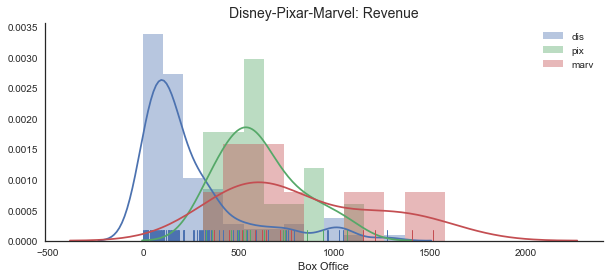

In [138]:
sns.set_style('white')
plt.figure(figsize=(10, 4))
binsr = np.linspace(0,2000,20)

var = {'dis':dis_only, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Disney-Pixar-Marvel: Revenue', fontsize=14)
plt.xlabel('Box Office')
plt.legend()
sns.despine()

#### Though we see that Disney's box-office revenue is a lot more skewed to the left (a lot less) compared to Marvel and Pixar... 

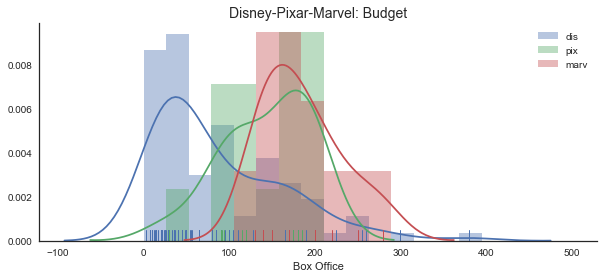

In [140]:
plt.figure(figsize=(10, 4))
binsb = np.linspace(0,500,20)

var = {'dis':dis_only, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True)
    
plt.title('Disney-Pixar-Marvel: Budget', fontsize=14)
plt.xlabel('Box Office')
plt.legend()
sns.despine()

#### ... we also see that the budgets for Disney's movies are similarly skewed to the left relative to the other two studios'.
- Excluding ***SOME*** unwanted lower-budget films gives us a closer comparison.
    - 

In [180]:
# filter lower-budget films; filter high-revenue films (threshold = "Pocahontas")
temp = dis_only.copy()[dis_only['budg'].apply(lambda x: x >= 85)]
temp1 = dis_only.copy()[dis_only['rev'].apply(lambda x: x >= 345)]

# combine to include all high-budget films and low-budget films with high box office
# done to include a few classic Disney films i.e., "Lion King"
disonly = pd.DataFrame(columns=dis_only.columns)
disonly = pd.concat([temp, temp1]).drop_duplicates()

# only manipulating dis_only df, because MAINLY* only disney movies were affected
a = pixar_only.budg
print("Smallest budget from Marvel movies: $" + str(np.amin(marv_only.budg)) + ' million')
print("Smallest budget from Pixar movies: $" + str(np.amin(a[a!=30])) + ' million')
print('\t-Including "low-budget" movies: "Toy Story" and "Toy Story 2".')
pixar_only.sort_values('budg').head(2)

Smallest budget from Marvel movies: $130.0 million
Smallest budget from Pixar movies: $90.0 million
	-Including "low-budget" movies: "Toy Story" and "Toy Story 2".


,index,Title,year,rev,budg,prof,genres,production_companies,popularity,vote_average,vote_count,release_date,studio,metric,kpi
96,1373,Toy Story,1995,373.554033,30.0,343.554033,"Animation,Comedy,Family",Pixar Animation Studios,73.640445,7.7,5269,1995-10-30,pixar,rev,373.554033
58,335,Toy Story 2,1999,497.366869,90.0,407.366869,"Animation,Comedy,Family",Pixar Animation Studios,73.575118,7.3,3806,1999-10-30,pixar,rev,497.366869


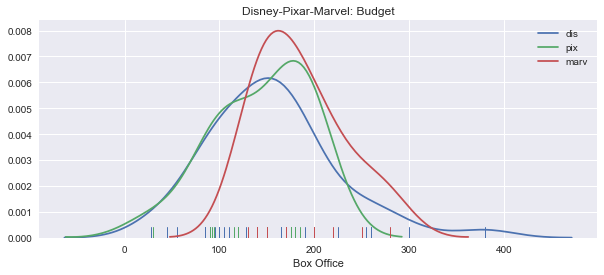

In [30]:
plt.figure(figsize=(10, 4))

var = {'dis':disonly, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True, hist=False)
    
plt.title('Disney-Pixar-Marvel: Budget', fontsize=14)
plt.xlabel('Box Office')
plt.legend()
sns.despine()

Now we see that the budget distribution for Disney is much **more comparable** with the other two studios'.

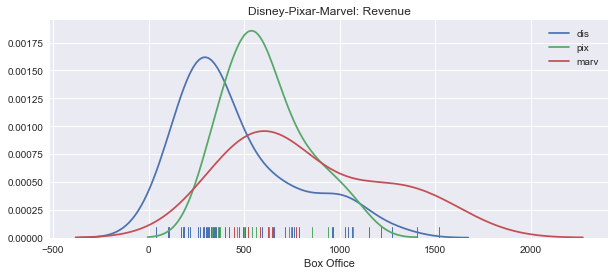

In [31]:
plt.figure(figsize=(10, 4))

var = {'dis':disonly, 'pix':pixar_only, 'marv':marv_only}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True, hist=False)
    
plt.title('Disney-Pixar-Marvel: Revenue', fontsize=14)
plt.xlabel('Box Office')
plt.legend()
sns.despine()

Once again utilizing our most-handiest of tools, the eye test, it appears Disney still underperforms relative to Pixar and Marvel.

In [32]:
print('count for: disney = ',  str(len(disonly)), '; pixar = ', str(len(pixar_only)), '; marvel = ', str(len(marv_only)))

count for: disney =  43 ; pixar =  16 ; marvel =  12


#### Since the individual studios have far less observations, combining the non-Disney studios and comparing that one portfolio of movies against Disney's movie library will make a better test.
- (maybe test individually afterwards if compelled)

In [33]:
marv_pixar = pd.concat([marv_only, pixar_only])

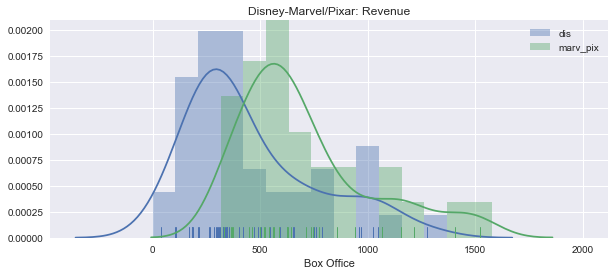

In [34]:
plt.figure(figsize=(10, 4))

var = {'dis':disonly, 'marv_pix':marv_pixar}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True, hist=True)
    
plt.title('Disney-Marvel/Pixar: Revenue', fontsize=14)
plt.xlabel('Box Office')
plt.legend()
sns.despine()

Checking the distributions of the test for **normality...**

In [35]:
stats.shapiro(dis_only['rev'])

(0.7641255855560303, 1.93934937553486e-11)

In [36]:
stats.shapiro(marv_pixar['rev'])

(0.8805892467498779, 0.0041374037973582745)

The marv_pix.rev distribution has a Shapiro-Wilk p-value that is greater than the significance level of 0.05.  This means that marv_pix.rev distribution does not deviate from a normal distribution.<br> However, the disrev1.rev distribution does depart from a normal distribution, so the Mann-Whitney U-test will be used. 

***
### Test


A significance level of 0.05 will be used for all of the tests.

In [37]:
stats.mannwhitneyu(disonly['rev'], marv_pixar['rev'])

MannwhitneyuResult(statistic=291.0, pvalue=0.00012949919833231204)

In [224]:
stats.mannwhitneyu(disonly['rev'], marv_only['rev'])

MannwhitneyuResult(statistic=99.0, pvalue=0.0006189751951051491)

In [225]:
stats.mannwhitneyu(disonly['rev'], pixar_only['rev'])

MannwhitneyuResult(statistic=192.0, pvalue=0.0048965059206004715)

#### Using the mwu-test on the revenues of Disney with Marv/Pixar returns a p-value that is much smaller than the significance level at 0.05.  <br>Therefore, we reject the null hypothesis that the difference between the two is due to randomness.
***
#### Due to the small number of movies available, it would not be prudent to try and group/filter the studios' movies further.

##### Moving forward, it will be assumed that further variable/feature groupings provide similar test results, which we can then make the conclusion that:
- Disney's performance has been driven by the successes of its *subsidiary studios*, as opposed to its main studio unit.
***
(side note)

In [38]:
# taken from the-numbers.com; box-office share of major studios
# a much more complete dataset
share = pd.read_csv('studioshare.csv')
share.rename(columns={'Share':'Percentage'}, inplace=True)

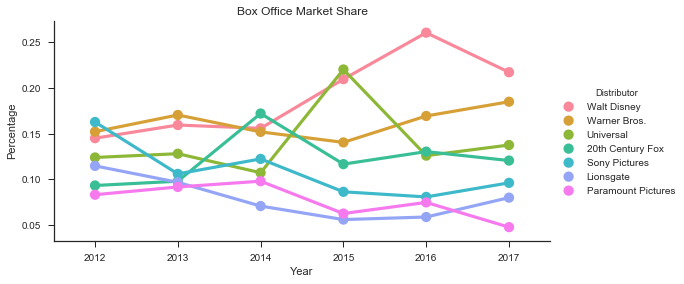

In [39]:
sns.set(style='ticks')
g = sns.factorplot(x='Year', y='Percentage', hue='Distributor', data=share, kind='point', aspect=2)
plt.title('Box Office Market Share')
plt.show()

#### Disney has been performing heads-and-shoulders above the other studios in recent years,

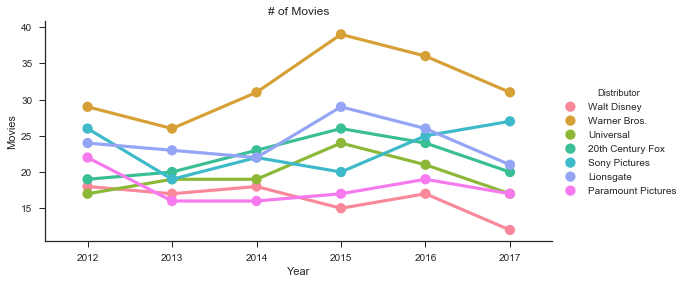

In [40]:
sns.set(style='ticks')
g = sns.factorplot(x='Year', y='Movies', hue='Distributor', data=share, kind='point', aspect=2)
plt.title('# of Movies')
plt.show()

#### doing so in spite of (or because of?) releasing the fewest films on average among the major studios (leading to an impressive average box office. 

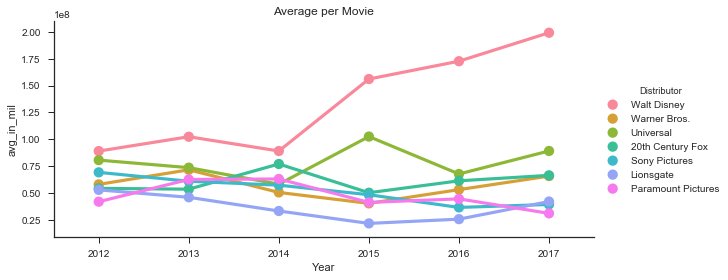

In [41]:
share['avg_in_mil'] = share['Gross']/share['Movies']

g=sns.factorplot(x='Year', y='avg_in_mil', hue='Distributor', data=share, kind='point', aspect=2.15)
plt.title("Average per Movie")

plt.show()

***
#### Since Disney is the best box-office performer by far, and Disney's subsidiaries perform better than Disney, we will take a closer look at Marvel and Pixar, and particularly about the "type" of movies they make. <br><br> 

In [42]:
# All of the 'genres' in the Box Office
genres_t = list(set([a for b in tmdb1.genres.str.split(',') for a in b]))
genres_t.sort()
genres_t

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western']

In [43]:
# the 'genres' in Marvel or Pixar
genres_mp = list(set([a for b in marv_pixar.genres.str.split(',') for a in b]))
genres_mp.sort()
genres_mp

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Drama',
 'Family',
 'Fantasy',
 'Science Fiction']

#### Compared to the industry, Marvel and Pixar produce within a narrower range of genres. <br><br> Before comparing the performance of the Box Office filtered by the genres of marv/pixar, we must remember that Marvel and Pixar produce exclusively high-budgeted movies (again, excluding "Toy Story").

In [44]:
a = marv_pixar.budg
print('The cheapest movie produced by Marvel/Pixar is ' + str(np.amin(a[a!=30])) + ' million dollars.  \nThis is compared to the industry budget average of ' + str(int(tmdb1.budg.mean())) + ' million dollars.')

The cheapest movie produced by Marvel/Pixar is 90.0 million dollars.  
This is compared to the industry budget average of 46 million dollars.


Controlling our variables and ensuring that our assumptions stay within the implied scope will reduce the chances of reaching an incorrect conclusion. 

#### The assumptions that are derived can then only apply to high-budgted films, or blockbusters.
***
##### Separating the genres of Marvel and Pixar

In [45]:
for genre in genres_t:
    tmdb1[genre] = tmdb1['genres'].str.contains(genre).apply(lambda x:1 if x else 0)

In [46]:
only_mp = tmdb1.loc[marv_pixar['index'], :].sort_index()

# non-Marvel/Pixar movies
mpindex = only_mp.index
no_mp = tmdb1.drop(mpindex)

In [47]:
# creating updated dfs with 'genres' feature included
only_marv = tmdb1.loc[marv_only['index'], :].sort_index()
only_pix = tmdb1.loc[pixar_only['index'], :].sort_index()

In [48]:
only_marv.loc[:, 'Action':'Western'].astype(bool).sum(axis=0).sort_values(ascending=False).head(4)

Action             12
Adventure          12
Science Fiction    10
Fantasy             2
dtype: int64

In [49]:
only_pix.loc[:, 'Action':'Western'].astype(bool).sum(axis=0).sort_values(ascending=False).head(7)

Animation    16
Family       16
Comedy       11
Adventure     7
Action        2
Fantasy       2
Drama         1
dtype: int64

<br>For Pixar, it is pretty cut and dry, where filtering by 'Animation', and maybe 'Family', is all that is needed.
<br><br>On the other hand, the key genre in Marvel movies is likely a combination of a few.  
- 'Action' and 'Adventure' show up in all Marvel movies, but Marvel movies are not necessarily representative of all 'Action'/'Adventure' movies that have ever been released.
- 'Science Fiction' shows up in 10 of 12 films (not including the two *Thor* movies, both of which relatively underperformed), but filtering by only 'Science Fiction' would include films that do not resemble a Marvel movie.
- 'Action' and 'Adventure' is nearly synonymous and interchangeable.  There is a distinction, but one that might be overlooked occasionally (incomplete/incorrect database when dataset was retrieved by contributors).
    - Therefore, creating a movie portfolio emulating Marvel's would include the genre combinations of ('Action' and/or 'Adventure) and 'Science Fiction', along with budget considerations.

In [50]:
act_scfi = no_mp.groupby(['Action', 'Science Fiction']).get_group((1,1))
adv_scfi = no_mp.groupby(['Adventure', 'Science Fiction']).get_group((1,1))
ani_ = no_mp.groupby('Animation').get_group(1)

In [51]:
box_off_mpgenres = pd.concat([act_scfi, adv_scfi, ani_])
box_off_mpgenres = box_off_mpgenres.drop_duplicates().sort_index()

In [172]:
# box_off_mpgenres = entire box office (of the given dataset), matching marvel/pixar genres
# budget >= $85m
box_off_mpgenres_85 = box_off_mpgenres[box_off_mpgenres.budg >= 85]

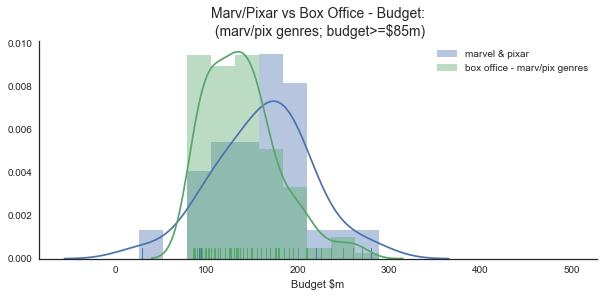

In [208]:
plt.figure(figsize=(10, 4))

var = {'marvel & pixar':only_mp, 'box office - marv/pix genres':box_off_mpgenres_85}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True)
    
plt.title('Marv/Pixar vs Box Office - Budget:\n (marv/pix genres; budget>=$85m)' ,fontsize=14)
plt.xlabel('Budget $m')
plt.legend()
sns.despine()

#### Having already filtered out for only "blockbuster" films \(<=\$85 million\), the distribution of budgets does not have as much overlap as with the Disney-Marvel-Pixar distribution of budgets.
- It would be possible to filter out more observations from the non-Marvel/Pixar distribution, <br>as there are only two observations in the Marvel/Pixar distribution with a** budget '<' \$100m**, so we could increase our threshold level accordingly
    - Used $90m previously for the Dis-Marv-Pix comparison

In [54]:
# box_off_mpgenres = entire box office (of the given dataset), matching marvel/pixar genres
# budget >= $100m
box_off_mpgenres_100 = box_off_mpgenres[box_off_mpgenres['budg'] >= 100]

In [55]:
print('The df went from ', str(len(box_off_mpgenres_85)), ' to ', str(len(box_off_mpgenres_100)), 'observations.')

The df only went from  149  to  128 observations.


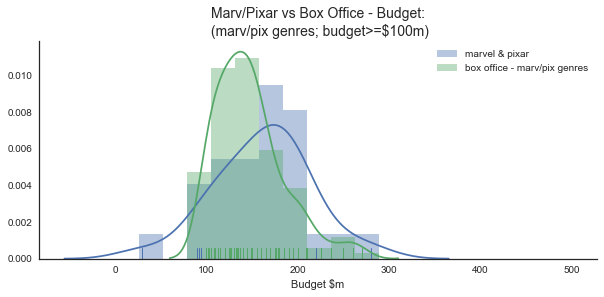

In [209]:
plt.figure(figsize=(10, 4))

var = {'marvel & pixar':only_mp, 'box office - marv/pix genres':box_off_mpgenres_100}
for k,v in var.items():
    sns.distplot(v.budg, binsb, label=k, rug=True)
    
plt.title('Marv/Pixar vs Box Office - Budget:\n (marv/pix genres; budget>=$100m)' ,fontsize=14)
plt.xlabel('Budget $m')
plt.legend()
sns.despine()

Even if less observations were eliminated than preferred, the new df with budget '>=' \$100m will be used regardless.

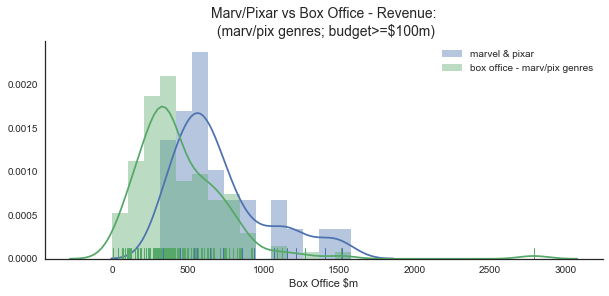

In [211]:
plt.figure(figsize=(10, 4))

var = {'marvel & pixar':only_mp, 'box office - marv/pix genres':box_off_mpgenres_100}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marv/Pixar vs Box Office - Revenue:\n (marv/pix genres; budget>=$100m)', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

The Mann-Whitney U test will continued to be employed (instead of normalizing the distribution and using a T-test).

### Test 
***

In [58]:
stats.mannwhitneyu(only_mp['rev'], box_off_mpgenres_100['rev'])

MannwhitneyuResult(statistic=866.0, pvalue=9.600402209762366e-06)

#### Results indicate that the difference in Marvel/Pixar movies and non-Marvel/Pixar movies are not due to random chance.
***
However, there are a couple issues with this test.
<br><br>
The first is that there is a significant difference in sample size.
<br>
Also, this comparison is ***only* in the genres that Marvel/Pixar operate in**.  While these genres are Marvel/Pixar's specializations, they are not necessarily any other studios' core focus.
<br><br>
Therefore, while we can use this test results to confirm Marvel/Pixar are the industry leaders in their respective genres, we **cannot determine** that Marvel/Pixar are better production studios overall than any other studio.
<br>
To be able to make that determination, there must be another test using different metrics or groupings.
***
####  Our initial goal was to determine the drivers of the Box Office. There is a distinction between: <br>a) Marvel/Pixar being the box-office drivers, and<br> b) the GENRES of Marvel/Pixar being the box-office drivers. 
- How to determine if Marvel/Pixar are the box-office drivers is complicated, as there is no obvious way to reach this conclusion.  
    -  For now, we will compare the performance of Marvel/Pixar relative to the other studios, and use this information later on when we set the conditions a studios must meet to be considered a driver of the Box Office.
- Determining if the genres that Marvel/Pixar operate in are the drivers of the Box Office is more straightforward, we simply **test** the **Box Office with the genres** against the **Box Office without the genres.**
    - Why this is simple and the Marvel/Pixar determination is not is because of  the sheer difference in the observation size between a couple of sub-studios and the entire Box Office.
        - keep in mind that the comparison is with the Box Office filtered for movies with a budget greater than \$100m.
***

##### We will continue to evaluate the performance of Marvel/Pixar against the other studios. 

While we have already performed a test on Disney and Disney's subsidiaries (Marvel/Pixar), that test did not filter out Disney's movies to match the genres of Marvel/Pixar.

In [175]:
# pulling Disney only movies with matching genres as marvel/pixar
# budg >= 100
dis_mpgenres_100 = box_off_mpgenres_100.groupby('dis').get_group(1)

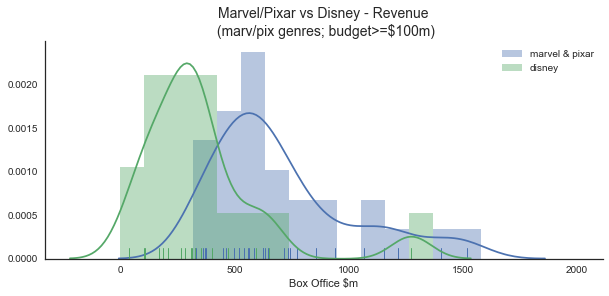

In [212]:
plt.figure(figsize=(10, 4))

var = {'marvel & pixar':only_mp, 'disney':dis_mpgenres_100}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel/Pixar vs Disney - Revenue\n (marv/pix genres; budget>=\$100m)', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

### Test
***

In [61]:
stats.mannwhitneyu(only_mp['rev'], dis_mpgenres_100['rev'])

MannwhitneyuResult(statistic=67.0, pvalue=8.423778733916771e-06)

When testing Disney for the Marvel/Pixar genres, **Disney performs** slightly better than the other studios in the "genre groupings" that Marvel/Pixar operate in, but stil **significantly less** than Marvel/Pixar.<br><br>
This does not necessarily signifiy anything bad, as it makes perfect sense to consider merger/acquisitions that **cover up your weaknesses**, which is what Disney did when they **purchased Marvel**.<br>
***

In [ ]:
disonly['Animation'] = disonly['genres'].str.contains('Animation').apply(lambda x:1 if x else 0)

In [232]:
dis_ani = disonly.copy().groupby('Animation').get_group(1)

In [219]:
dis_nonani = disonly.copy()[disonly['budg']>=95].groupby('Animation').get_group(0)

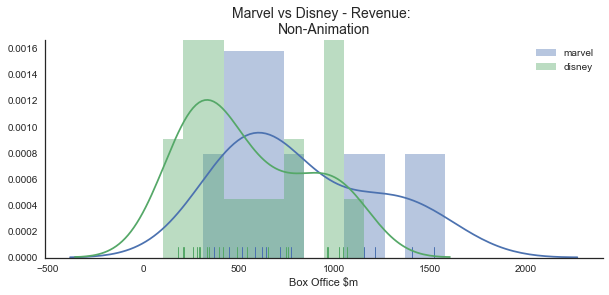

In [220]:
plt.figure(figsize=(10, 4))

var = {'marvel':marv_only, 'disney':dis_nonani}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel vs Disney - Revenue: \nNon-Animation', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()

sns.despine()

### Test
***

In [221]:
stats.mannwhitneyu(marv_only['rev'], dis_nonani['rev'])

MannwhitneyuResult(statistic=67.0, pvalue=0.014287249655647451)

#### Test results indicate that Marvel outperforms Disney's 'non-Animation' movies.
- did not match genres as key Disney movies would have been excluded (i.e., "Pirates of the Caribbean")
- used higher budget threshold of $95m to get a more optimal revenue distribution for Disney
<br><br>
***
However, Pixar can be seen as a direct competitor to Disney's hallmark 'Animation' movies.
- A possible reason why Pixar was acquired by Disney is if Pixar was seen as a threat

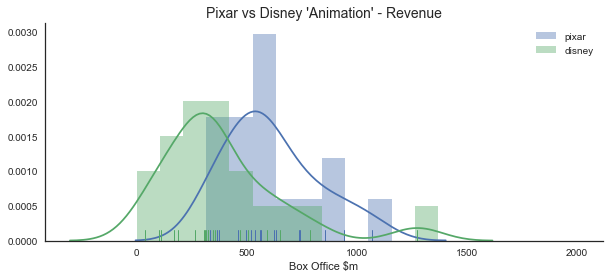

In [233]:
plt.figure(figsize=(10, 4))

var = {'pixar':pixar_only, 'disney':dis_ani}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title("Pixar vs Disney 'Animation' - Revenue", fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()

sns.despine()


### Test
***

In [234]:
# not filtering Disney by budget>=$100m because of our previous analysis with Dis
# showing a few movies with budget<$100m that helped the revenue distribution
stats.mannwhitneyu(pixar_only['rev'], dis_ani['rev'])

MannwhitneyuResult(statistic=60.0, pvalue=0.0012233041578901714)

#### Pixar outperforms Disney in the quintessential genre for the two studios, 'Animation'. 
- despite 'Animation' being a longtime focus of Disney's, around the time Pixar came into being, they [posed a very existential threat to Disney](https://variety.com/2016/film/features/disney-pixar-acquisition-bob-iger-john-lasseter-1201923719/)
<br> 
<br>

So, it can be said that Disney benefitted from the acqusition of both studios.
***
##### Comparing the 'Animation' movies of studios to Pixar

In [68]:
# assigning the 'genres features' to each studio

list_studiosdf = [fox, wb, univ, sony, para, lgf]

for studio in list_studiosdf:
    for genre in genres_t:
        studio[genre] = studio['genres'].str.contains(genre).apply(lambda x:1 if x else 0)

In [69]:
colus = ['Title', 'kpi', 'metric', 'studio']


# 'Animation' movies
tmdba1 = tmdb1.copy().groupby('Animation').get_group(1)
tmdba = tmdba1[tmdba1['budg']>=85]

In [70]:
# slice 1:-1 to exclude Disney and Lionsgate (has no 'Animation')
studios_rev_a = ftr_groupby(list_studios[1:-1], ('Title', 'rev'), tmdba)
studios_budg_a = ftr_groupby(list_studios[1:-1], ('Title', 'budg'), tmdba)
studios_concan_a0 = pd.concat([studios_rev_a, studios_budg_a])

# adding in disney and pixar separately 

In [71]:
# # ignore warnings related to creating column of string
# import warnings
# warnings.filterwarnings("ignore")

In [72]:
# using previously created dfs to join to 
pixar_only['studio'] = 'pixar'
dis_ani['studio'] = 'dis'

# update kpi/metric with every use (run from the start)
dis_ani['kpi'] = dis_ani['budg'].copy()
dis_ani['metric'] = 'budg'
pixar_only['metric'] = 'budg'
pixar_only['kpi'] = pixar_only['budg'].copy()

# concantenating studios
studios_concan_a1 = pd.concat([dis_ani.loc[:, colus], studios_concan_a0, pixar_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [73]:
# add dis & pixar rev/budg separately

dis_ani['kpi'] = dis_ani['rev'].copy()
pixar_only['kpi'] = pixar_only['rev'].copy()
dis_ani['metric'] = 'rev'
pixar_only['metric'] = 'rev'

# concantenating
studios_concan_a = pd.concat([dis_ani.loc[:, colus], studios_concan_a1, pixar_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
# warnings.filterwarnings("default")

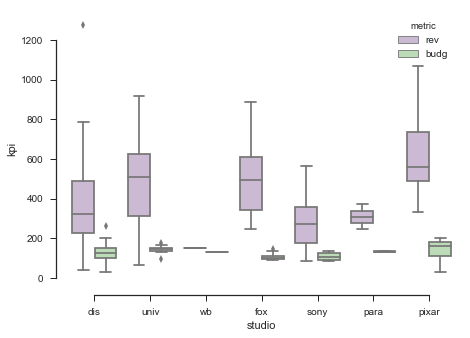

In [75]:
sns.set(style="ticks", )
ax, fig = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="studio", y='kpi', hue='metric', data=studios_concan_a, palette="PRGn")
sns.despine(offset=10, trim=True)

Instead of testing each studio with Pixar, testing Universal and Fox would be all that is required to determine if Pixar is superior to the other studios.
### Test
***

In [76]:
# 'Animation' for Universal and Fox
univ_a = univ.groupby('Animation').get_group(1)
fox_a = fox.groupby('Animation').get_group(1)

In [192]:
# budget>=85
univ_a85 = univ_a[univ_a['budg']>=85]
fox_a85 = fox_a[fox_a['budg']>=85]

In [196]:
stats.mannwhitneyu(pixar_only['rev'], univ_a85['rev'])

MannwhitneyuResult(statistic=125.0, pvalue=0.06771024362601179)

In [197]:
stats.mannwhitneyu(pixar_only['rev'], fox_a85['rev'])

MannwhitneyuResult(statistic=44.0, pvalue=0.11621429326753663)

***
**Increasing the budget threshold does not always produce a better revenue** distribution for a studio, as some of the "lower" budget movies could generate a high box office.
- this was the case for "Toy Story", that had a budget of \$30m compared to a revenue of over \$300m

In [195]:
# budget>=100
univ_a100 = univ_a[univ_a['budg']>=100]
fox_a100 = fox_a[fox_a['budg']>=100]

In [200]:
stats.mannwhitneyu(pixar_only['rev'], univ_a100.rev)

MannwhitneyuResult(statistic=125.0, pvalue=0.09630085038077979)

In [201]:
stats.mannwhitneyu(pixar_only['rev'], fox_a100['rev'])

MannwhitneyuResult(statistic=12.0, pvalue=0.03269541147338109)

And is also **the case for Universal**, as increasing the budget to \$100m increases the p-value, and the probability that the difference between **Universal** and **Pixar** occurred by chance.<br><br>
From Fox, the results of increasing the budget threshold to \$100m has the expected effect, where the p-value, and the probability that the difference between Universal and Pixar occurred by chance, decreases.
- p-value decreases below the significance level
- **will evaluate with the $85m budget threshold due to more observations**
***

##### Pixar is not significantly different from the 'Animation' movies of either Universal or Fox.

Comparing Pixar with the Box Office as a whole would undoubtedly strengthen Pixar's p-value, as the other studios bring down the average revenue of 'Animation' films.

However, as mentioned earlier about the strengths and weaknesses of each studio, testing with the other industry leaders is preferred in order to achieve a stronger confirmation.

Given that Pixar's distribution is still on the higher side, we may say that though Pixar's movies are **not significantly better than every studio's 'Animation' films**, Pixar is still *the* leader when it comes to 'Animation'.
***

##### Testing Marvel against other studios

In [80]:
colus = ['Title', 'kpi', 'metric', 'studio']


# non-Animation movies; budg>=85
tmdbna0 = tmdb1.copy().groupby('Animation').get_group(0)
tmdbna = tmdbna0[tmdbna0['budg']>=100]

In [81]:
studios_rev_na = ftr_groupby(list_studios[1:], ('Title', 'rev'), tmdbna)
studios_budg_na = ftr_groupby(list_studios[1:], ('Title', 'budg'), tmdbna)
studios_concan_na0 = pd.concat([studios_rev_na, studios_budg_na])

In [82]:
# warnings.filterwarnings('ignore')

In [83]:
marv_only['studio'] = 'marv'
dis_nonani['studio'] = 'dis'

# update kpi/metric with every use
dis_nonani['kpi'] = dis_nonani['budg'].copy()
dis_nonani['metric'] = 'budg'
marv_only['metric'] = 'budg'
marv_only['kpi'] = marv_only['budg'].copy()

studios_concan_na1 = pd.concat([dis_nonani.loc[:, colus], studios_concan_na0, marv_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [84]:
dis_nonani['kpi'] = dis_nonani['rev'].copy()
marv_only['kpi'] = marv_only['rev'].copy()
dis_nonani['metric'] = 'rev'
marv_only['metric'] = 'rev'

studios_concan_na = pd.concat([dis_nonani.loc[:, colus], studios_concan_na1, marv_only.loc[:,colus]])

C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [85]:
# warnings.filterwarnings('default')

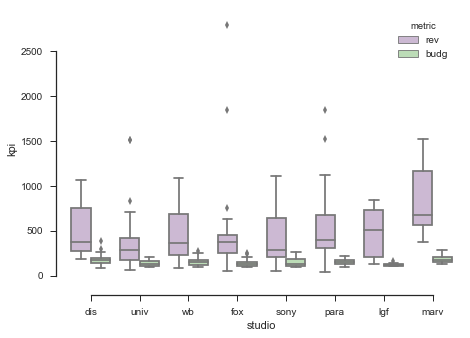

In [86]:
sns.set(style="ticks", )
ax, fig = plt.subplots(figsize=(7,5))
ax = sns.boxplot(x="studio", y='kpi', hue='metric', data=studios_concan_na, palette="PRGn")
sns.despine(offset=10, trim=True)

It does not appear necessary to test the studios against Marvel, as Disney seems to have the best distribution out of the rest (supported by the histogram below), and we know from before, Marvel is superior to Disney.
- However, we will refrain from making any assumptions attributed to this plot.
***
##### Testing Marvel and Pixar against the combined Box Office

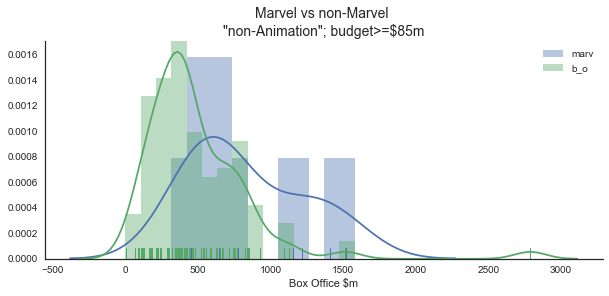

In [246]:
plt.figure(figsize=(10, 4))

bo_marvgenres = pd.concat([act_scfi, adv_scfi]) # already no_mp
bo_marvgen = bo_marvgenres[bo_marvgenres['budg']>=100]

var = {'marv':marv_only, 'b_o':bo_marvgen}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel vs non-Marvel \n"non-Animation"; budget>=$100m', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

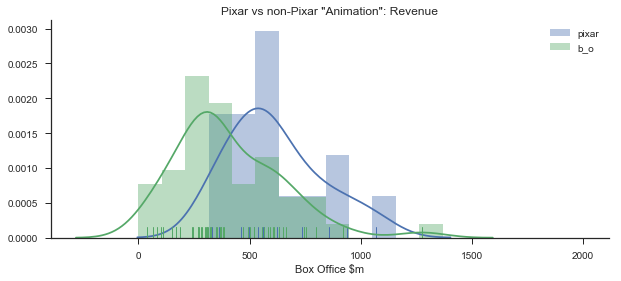

In [90]:
plt.figure(figsize=(10, 4))

ani_100 = ani_[ani_.budg>=100]

var = {'pixar':pixar_only, 'b_o':ani_100}
for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Pixar vs non-Pixar \n"Animation"; budget>=$100m', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

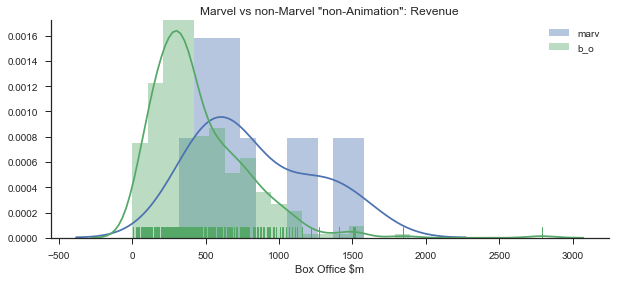

In [91]:
plt.figure(figsize=(10, 4))

tmdb100 = tmdb1[tmdb1.budg >=100]

var = {'marv':marv_only, 'b_o':tmdb100}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Marvel vs non-Marvel "non-Animation": Revenue', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

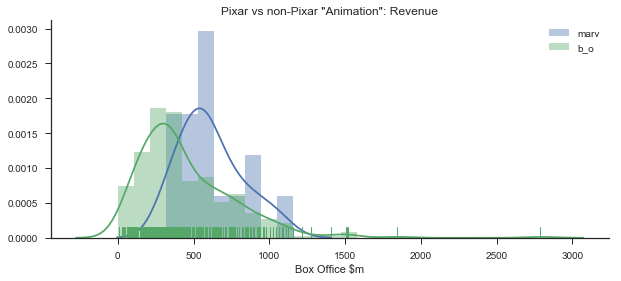

In [92]:
plt.figure(figsize=(10, 4))

tmdb100 = tmdb1[tmdb1.budg >=100]

var = {'pixar':pixar_only, 'b_o':tmdb100}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Pixar vs non-Pixar "Animation": Revenue', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

### Test
***

In [93]:
stats.mannwhitneyu(marv_only.rev, tmdb100.rev)

MannwhitneyuResult(statistic=755.0, pvalue=0.00019091481077997106)

In [94]:
stats.mannwhitneyu(pixar_only.rev, tmdb100.rev)

MannwhitneyuResult(statistic=1452.0, pvalue=0.001888948165765181)

In [245]:
stats.mannwhitneyu(marv_only.rev, bo_marvgen.rev)

MannwhitneyuResult(statistic=369.0, pvalue=0.0003255463827536072)

In [96]:
stats.mannwhitneyu(pixar_only.rev, ani_100.rev)

MannwhitneyuResult(statistic=186.0, pvalue=0.0008755741727218457)

**Marvel and Pixar both perform better than the Box Office as a whole*, and when filtering by their respective 'genres'.**
- (this actually included their movies into the Box Office comparison, but as their revenues are higher than the average, it does not invalidate the results.)
<br><br>

We have covered the performance of Marvel and Pixar against the Box Office and a few individual studios, and<br>
**with this, one of the questions (if Marvel and Pixar are drivers of the Box Office) is just about fully answered, but will be continued later.**
***
The next question is in regards to the **'genres'** of Marvel/Pixar being the **box-office drivers.**
##### Grouping the Box Office by movies with marv/pixar 'genres', and movies w.o marv/pixar 'genres'

In [97]:
act_scfi1 = tmdb1.groupby(['Action', 'Science Fiction']).get_group((1,1))
adv_scfi1 = tmdb1.groupby(['Adventure', 'Science Fiction']).get_group((1,1))
ani_1 = tmdb1.groupby(['Animation', 'Family']).get_group((1,1))

# Box Office of marvel's and pixar's genres
# includes marvel and pixar
mp_bo = pd.concat([act_scfi1, adv_scfi1, ani_1])
mp_bo = mp_bo.drop_duplicates().sort_index()
mp_bo1 = mp_bo[mp_bo.budg>=85]

# box_off_mpgenres does not include marvel/pixar

In [98]:
mpbo_ind = mp_bo.index
non_mpbo = tmdb1.drop(mpbo_ind)

non_mpbo1 = non_mpbo[non_mpbo.budg>=85]

### Test
***

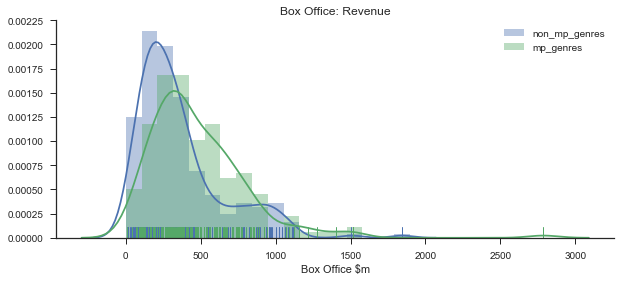

In [99]:
# includes Marvel and Pixar movies

plt.figure(figsize=(10, 4))

var = {'non_mp_genres':non_mpbo1, 'mp_genres':mp_bo1}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [100]:
stats.mannwhitneyu(mp_bo1.rev, non_mpbo1.rev)

MannwhitneyuResult(statistic=14514.5, pvalue=1.3241582593312192e-06)

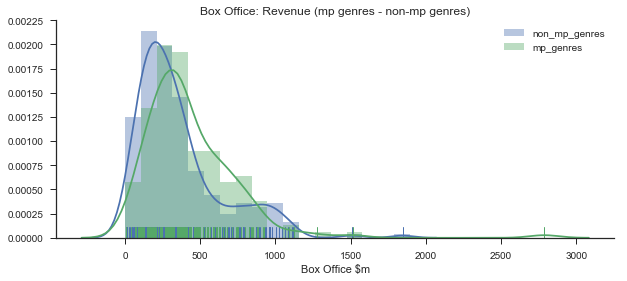

In [101]:
# does not include Marvel and Pixar movies

plt.figure(figsize=(10, 4))

var = {'non_mp_genres':non_mpbo1, 'mp_genres':box_off_mpgenres_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue (mp genres - non-mp genres)', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [102]:
stats.mannwhitneyu(box_off_mpgenres_85.rev, non_mpbo1.rev)

MannwhitneyuResult(statistic=13961.5, pvalue=0.0004112452123619021)

Regardless of whether Marvel and Pixar movies are included or not, **the Box Office with Marvel/Pixar 'genres' is significantly better than non-Marvel/Pixar 'genres'.**
***
##### Testing Marvel and Pixar 'genres' separately

In [103]:
marvgen_bo = pd.concat([act_scfi1, adv_scfi1], axis=0)
marvgen_bo_85 = marvgen_bo[marvgen_bo['budg']>=85]

In [104]:
nonmarvgen_bo = tmdb1.drop(marvgen_bo.index)
nonmarvgen_bo_85 = nonmarvgen_bo[nonmarvgen_bo['budg']>=85]

### Test

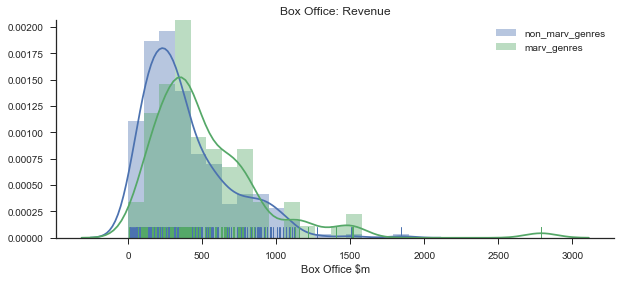

In [105]:
# includes Marvel

plt.figure(figsize=(10, 4))

var = {'non_marv_genres':nonmarvgen_bo_85, 'marv_genres':marvgen_bo_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [106]:
stats.mannwhitneyu(marvgen_bo_85.rev, nonmarvgen_bo_85.rev)

MannwhitneyuResult(statistic=19179.5, pvalue=2.6221978955284797e-06)

In [107]:
nmarvgen_bo_85 = marvgen_bo_85.drop(marv_only.set_index('index').index)

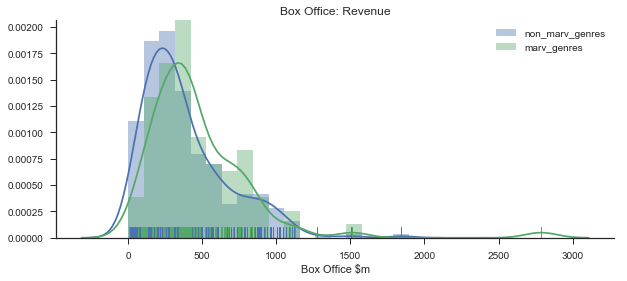

In [108]:
# does not include Marvel

plt.figure(figsize=(10, 4))

var = {'non_marv_genres':nonmarvgen_bo_85, 'marv_genres (not incl. marv)':nmarvgen_bo_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue w/ budget>=$85m', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [109]:
stats.mannwhitneyu(nmarvgen_bo_85.rev, nonmarvgen_bo_85.rev)

MannwhitneyuResult(statistic=18373.5, pvalue=0.0005311436910908813)

The **'genres' of Marvel ('Action'|'Adventure' & 'Science Fiction') show significantly better performance** at the Box Office than the other 'genres'.
    - true including/excluding Marvel movies
***
##### Testing Pixar genres

In [110]:
pixgen_bo = ani_1.copy() # same as how marvgen_bo is created
pixgen_bo_85 = pixgen_bo[pixgen_bo['budg']>=85]

In [111]:
non_pixgen_bo = tmdb1.drop(pixgen_bo.index)
non_pixgen_bo_85 = non_pixgen_bo[non_pixgen_bo['budg']>=85]

### Test
***

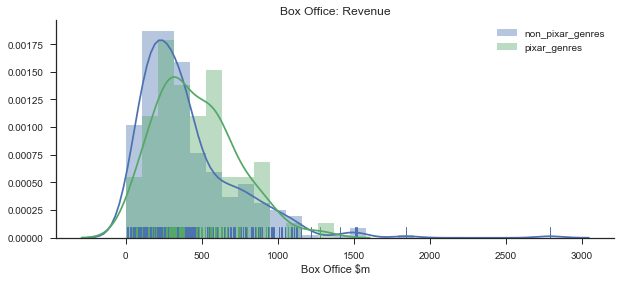

In [112]:
# includes Pixar

plt.figure(figsize=(10, 4))

var = {'non_pixar_genres':non_pixgen_bo_85, 'pixar_genres':pixgen_bo_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue w/ budget>=$85m', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [113]:
stats.mannwhitneyu(non_pixgen_bo_85.rev, pixgen_bo_85.rev)

MannwhitneyuResult(statistic=9443.0, pvalue=0.007635719859348923)

In [145]:
npixgen_bo_85 = pixgen_bo_85.drop(pixar_only.iloc[:-1, :].set_index('index').index)

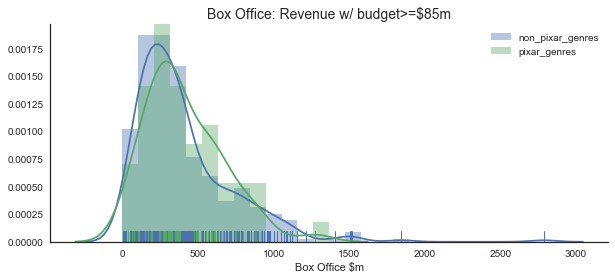

In [146]:
# does not include Pixar

plt.figure(figsize=(10, 4))

var = {'non_pixar_genres':non_pixgen_bo_85, 'pixar_genres':npixgen_bo_85}

for k,v in var.items():
    sns.distplot(v.rev, binsr, label=k, rug=True)
    
plt.title('Box Office: Revenue w/ budget>=$85m', fontsize=14)
plt.xlabel('Box Office $m')
plt.legend()
sns.despine()

In [147]:
stats.mannwhitneyu(non_pixgen_bo_85.rev, npixgen_bo_85.rev)

MannwhitneyuResult(statistic=8325.0, pvalue=0.1658040165679575)

In contrast to the 'genres' of Marvel, **'Animation' movies** - essentially Pixar's 'genres' - does **not perform better** than non-Animation movies if **Pixar's movies are not included**.
- If **Pixar movies are included**, 'Animation' movies **perform better than non-Animation movies.**
***
***

***We will stop the exploration/discovery section here**, now that the **first core assumptions have been found.**
- From these tests, we are able to determine that certain **studios** do perform better than others.
- We are also able to determine that there are certain **'genres'** (in either their variable or feature formatting) that perform better than others.

#### For our experiment, our hypotheses will stem from these assumptions, but we must be careful not to cross the parameters of our findings.
- We have primarily focused on Disney and its sub-studios only
    - Assumptions about each studios have not been established
- While we determined that the 'genres' of Marvel - and Pixar to a lesser degree - perform better than the other 'genres', that comparison was done with the other 'genres' as a whole, not comparing with each separate 'genres'.
<br>
<br>
***
When performing tests for the experiment, we are hoping to see if manipulating certain variables will result in a change in the dependent variable (revenue) that is aligned with what was discovered.
- In this case, the variables being manipulated are studios and 'genres'.
    - Though the two features may be related in this context - due to the 'genres' we used for our base case having been derived from the same studios that was used for that feature's base case analysis
    - in an actual experiment, assumptions would have been made for all of the 'genres' available, so there would be more context about the relationships of the 'genres' than "marv/pix 'genres' are better than other 'genres'"
***
***

## Variable Manipulation
***
The variables in this dataset are what make up a movie.  However, we want to be able to **manipulate these variables without changing the actual movie**.  The reason being that it is **not**:
1. financially feasible
2. [always possible](https://mashable.com/2018/05/15/henry-cavill-mustache/#R5uiqRieymqt)
3. what we want
    - as the quality of a movie itself could be the reason for the difference in revenue, changing the actual movie itself would also affect the quality, for better or worse
<br>
<br>

***How can these variable be manipulated without also drastically changing the product itself?***<br> <br>
**Trailers** are where consumers get most of their information about a movie, and will be where most of the manipulation has to take place.<br>
Altering a **variable** on a printed medium is simple enough, but how can the genre of a trailer be manipulated without also changing the genre of the movie? <br>Well, the filmmaker themselves are not always directly involved in making trailers, which has more to do with marketing and may be considered out of the filmmaker's expertise. So, 
- **trailers do not always include clips** that make the final cut of the movie, and
- **trailers can include scenes that evoke certain genres** over others, but not one that is consistent with the entire movie.

The first point has become a recent topic of contention among [moviegoers](https://www.independent.co.uk/arts-entertainment/films/news/suicide-squad-fan-suing-studio-false-advertising-lack-of-joker-scenes-jared-leto-warner-bros-a7180231.html), and even among the [actors](https://www.cinemablend.com/news/1546480/jared-leto-is-apparently-really-upset-about-suicide-squad-heres-what-happened) themselves, when the final cut of a movie excludes a lot of what was the most anticipated material from the movie in the first place. 

The second point - introducing some first-hand, personal experiences to the research - can best be symbolized by Edgar Wright's *Baby Driver*.  <br>
When I watched the trailer when it first came out, I got a bit more of an overall happy vibe from the [trailer](https://www.youtube.com/watch?v=D9YZw_X5UzQ), in parts because of the music, the [color grading](https://www.youtube.com/watch?v=hpWYtXtmEFQ), and because the characters are doing some very [stupid things](https://www.youtube.com/watch?v=kOnQocd799Y) in a crime movie.  <br> 
The movie was darker than expected, but it felt forced and awkward.  The [review](https://www.nytimes.com/2017/06/27/movies/baby-driver-review-edgar-wright-ansel-elgort.html) insists you will go on a "genre ride" and that "it's easy to go with Mr. Wright's flow, partly because he rarely steps off the gas".<br>
For those same reasons, I thought the movie suffered from an identity crisis.  For each genre present in the movie, there were a couple scenes taken to the extreme just to be able to "include" that genre.  <br>
At times, the movie was unattractively brazen about it (all the singing and dancing for one); at other times, the characters' actions were just baffling (fingerprints everywhere).
<br>Needless to say more, I did not particularly enjoy the movie.
- (of course, the flip side of this is that I read that exact review **before** I watched the movie, which makes that review an influencing variable as well)

Considering that such instances of trailer-to-movie manipulation does exist, then that can be transferred over in an actual experiment setting. (this trailer-to-movie manipulation would be able to manipulate just about all variables)<br>

Though manipulating trailers would be the preferred for all variables, it is more doable for some variables than others.
- "Movie test-screenings" would be even less feasible, and more complicated to manipulate variables for 20 minutes of uninterrupted content than a 2 minute collection of scene cuts.

"Manipulating" variables by changing words on a paper can be done simply enough, but the impact of that form of manipulation would first have to be captured and significant enough relative to the impact of manipulating variables in a digital medium to be used.
- possibly can be done simultaneously

#### To summarize briefly, the effects of some variable-manipulations can be captured simply through a printed medium, whereas other variable-manipulations must be done through a digital medium, but it will not always be possible for all variables\*. 


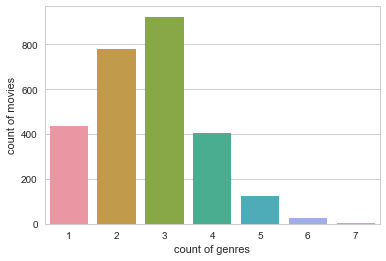

In [114]:
tmdb_gen = tmdb1['genres'].apply(lambda x: len(x.split(',')))

sns.set_style('whitegrid')
ax = sns.countplot(x=tmdb_gen)
ax.set(xlabel='count of genres', ylabel='count of movies')
plt.show()

\* Not all genres can be manipulated, erased, or hidden in a trailer.  It would take a great amount of work to hide the fact that a Star Wars movie is gonna be based in science fiction.  It could be done theoretically, but the finished product might not resemble a trailer.
<br>Movies are more likely to have a few genres than one, but there are still quite a few movies with just one genre.

In both cases where at least one genre has to exist in the trailer, then muting that particular genre in the trailer in favor of another genre (may not make sense for all genres; may not necessarily care about all genres) appears to be the best option when completely hiding a genre is not possible.

There are also **external factors that are not able to be controlled or manipulated** to account for:
- i.e., a variable we can consider is the seasonality of a movie's release date
- does changing the time of year a movie is released lead to a significant departure from the expected mean of the dependent variable (revenue)?
- is there a preferred/better time of year for movie releases?
***
***

## Experiment
***
Samples will be randomly selected and randomly assigned to two groups, the control and the experiment. 
- Samples are trailers for movies

The control group will be exposed to variables in their original state, while the experiment group will be exposed to manipulated variables.
- manipulate the 'genres' in trailers to include 'Sci-Fi' and take away 'Fantasy'
- replace a studio's logo with Marvel's

Pretests may be in the form of showing movies in their original state if the experiment shows two different types of changes to a movie
- one group has a trailer to have more 'Action';
- other group's trailer has more 'Adventure' 
    - note* the two 'genres' are actually distinct, just happens to overlap often; 

**The question** - measure of KPI
- How likely are they to watch the movie? 
- How many times would they watch movie in theaters? 
-  **Would you recommend the trailer?** 
    - especially important as, despite our datset not including social media data, crowdsourcing is a powerful tool and would be important information

Trailers are manipulated based on which variables' effect we are hoping capturing for that particlar test (all independent variables that can be manipulated will be tested).

#### Variables
- 'Actors' - since trailers do not need to include too many scenes of the main actors, they can be manipulated as well; or vice versa, trailers can highlight an actor who [dies in the first 12 minutes](https://en.wikipedia.org/wiki/G.I._Joe:_Retaliation) of the film. 
    - realistically, the test for 'actors' will likely be restricted to surveys
        - would you be more likely to watch this movie if the main actor was replaced by Ryan Gosling (yes)
    - may be possible to show participants audition tapes 
        - limits possible values to pool of applicants
        - realistically, not possible; hypothetically, possibly useful
- 'production_companies' (studios) - easily manipulated, switch out the studio logos that are shown 
- 'genres' - talked about earlier, able to be manipulated as well
- 'keywords' & 'tagline' - can be manipulated through trailers similar to 'genres'
    - can be thought of as changing the narrative of the 'trailer'

#### Additional Helper

In [115]:
studios = list(set(a for b in tmdb['production_companies'].str.split(',') for a in b))
studios1 = list(set(a for b in tmdb1['production_companies'].str.split(',') for a in b))

In [116]:
for s in studios:
    if 'Fox' in s:
        print(s)

Fox Animation Studios
Foxtor Productions
Twentieth Century Fox Television
Sodium Fox
20th Century Fox Home Entertainment
20th Century Fox Russia
Fox Searchlight Pictures
Fox Entertainment Group
Fox Filmes do Brasil
Fox Family Films
Fox Films Ltd.
Twentieth Century Fox Film Corporation
Fox 2000 Pictures
Fox Atomic
Twentieth Century Fox Animation
Foxstar


In [117]:
for s in studios1:
    if 'Disney' in s:
        print(s)

Disney Toon Studio
Disney World Cinema
Walt Disney Television Animation
Walt Disney Animation Canada
Walt Disney Feature Animation
Disney
Walt Disney Animation Australia
Walt Disney Animation Studios
Walt Disney Studios Motion Pictures
Walt Disney
Walt Disney Pictures
DisneyToon Studios
